# **RNN (LSTM) Model for Human Action Recognition**

___
___

## **1. INITIALIZATION**

### *1.1. IMPORTS*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import time

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn

To fill the [**requirement.txt**](../requirement.txt) file we use the following line of code:

In [2]:
import session_info
session_info.show()

In [3]:
# setting the device as the GPU if available, else the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


### *1.2. DATA LOADING*

In [4]:
data2D_dir = "data/nturgbd60_skeletons_2D/"
data3D_dir = "data/nturgbd60_skeletons_3D/"

data2D_files = os.listdir(data2D_dir)
data3D_files = os.listdir(data3D_dir)

In [5]:
with open("./data/actions.txt", 'r') as actions_file:
    actions = [line.replace('\n', '') for line in actions_file.readlines()]
    actions_file.close()

In [6]:
classes = [5, 6, 7, 8, 14, 24, 30, 32, 42]
for i,elem in enumerate(classes):
    print("class {} : {}".format(i, actions[elem]))

class 0 : pickup
class 1 : throw
class 2 : sitting down
class 3 : standing up (from sitting position)
class 4 : take off jacket
class 5 : reach into pocket
class 6 : pointing to something with finger
class 7 : check time (from watch)
class 8 : falling


In [7]:
class HumanActionDataset2D(Dataset):

    def __init__(self, data_dir, data_files, classes, normalized=True, with_depth=True, flatten=False):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.with_depth = with_depth
        self.flatten =  flatten
        self.normalized = normalized

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if self.normalized:
            tensor[:,:,0] = tensor[:,:,0]/1920-0.5
            tensor[:,:,1] = tensor[:,:,1]/1080-0.5
        if not self.with_depth:
            tensor = tensor[:,:,:2]
        if self.flatten:
            tensor = tensor.reshape((tensor.shape[0], tensor.shape[1]*tensor.shape[2]))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

We also build a dataset in which we are going to mask some joints to see if our model is robust enough to missing data.

In [8]:
class HumanActionDataset3D(Dataset):

    def __init__(self, data_dir, data_files, classes, flatten=False):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.flatten =  flatten

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if self.flatten:
            tensor = tensor.reshape((tensor.shape[0], tensor.shape[1]*tensor.shape[2]))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [9]:
HAD2D = HumanActionDataset2D(data2D_dir, data2D_files, classes, with_depth=False, flatten=True)
HAD3D = HumanActionDataset3D(data3D_dir, data3D_files, classes, flatten=True)

Here we are going to use PyTorch’s DataLoader with Variable Length Sequences for LSTM/GRU : from this [article](https://www.codefull.net/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/).

In [10]:
class PadSequence():

    def __call__(self, batch):

        # let's assume that each element in "batch" is a tuple (data, label).
        # the following line of code sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        
        # then we take each sequence of the batch and pad it
        sequences = [x[0] for x in sorted_batch]
        sequences_padded_end = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)

        lengths = torch.LongTensor([len(x) for x in sequences])

        # here we adjust the padding because we want zeros at the beginning
        # (we had poor results with zeros at the end)
        sequences_padded_begin = torch.stack(
            [torch.cat([
                sequences_padded_end[i][lengths[i]:],
                sequences_padded_end[i][:lengths[i]]]
            ) for i in range(len(sequences_padded_end))]
        )

        # don't forget to grab the labels of the *sorted* batch
        labels = torch.LongTensor([x[1] for x in sorted_batch])
        return sequences_padded_begin, lengths, labels

We use 80% of the data for training and the remaining 20% for validation.

In [11]:
train_dataset2D, val_dataset2D = torch.utils.data.random_split(HAD2D, [int(0.80*len(HAD2D)), len(HAD2D)-int(0.80*len(HAD2D))])
train_dataset3D, val_dataset3D = torch.utils.data.random_split(HAD3D, [int(0.80*len(HAD3D)), len(HAD3D)-int(0.80*len(HAD3D))])

train_dataloader2D = torch.utils.data.DataLoader(dataset=train_dataset2D, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader2D = torch.utils.data.DataLoader(dataset=val_dataset2D, batch_size=32, collate_fn=PadSequence(), shuffle=True)

train_dataloader3D = torch.utils.data.DataLoader(dataset=train_dataset3D, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader3D = torch.utils.data.DataLoader(dataset=val_dataset3D, batch_size=32, collate_fn=PadSequence(), shuffle=True)

### *1.3 AUXILIARY FUNCTIONS*

In [12]:
def train_model(model, criterion, optimizer, nb_epochs, epoch_print_frequence, train_dataloader, val_dataloader):

    s = time.time()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(nb_epochs):
        
        running_loss_train, running_loss_val, running_acc_train, running_acc_val = 0, 0, 0, 0

        for train in [True, False]:

            if train:
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            for data in dataloader:
                
                inputs = data[0].to(device)
                labels_raw = data[-1]
                labels = torch.zeros((inputs.shape[0], len(classes)))
                for i in range(len(labels_raw)):
                    labels[i][int(labels_raw[i])] = 1
                labels = labels.to(device)

                if train:
                    optimizer.zero_grad()

                outputs_for_loss,_,_ = model(inputs)
                sm = nn.Softmax(dim=1).to(device)
                outputs = sm(outputs_for_loss)
                outputs = outputs.to(device)
                loss = criterion(outputs_for_loss, labels)

                if train:
                    loss.backward()
                    optimizer.step()
                    running_loss_train += loss.item()
                    running_acc_train += int(torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1)))
                else:
                    running_loss_val += loss.item()
                    running_acc_val += int(torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1)))

        running_loss_train /= len(train_dataloader)
        running_loss_val /= len(val_dataloader)
        running_acc_train /= len(train_dataset2D)
        running_acc_val /= len(val_dataset2D)

        train_losses.append(running_loss_train)
        val_losses.append(running_loss_val)
        train_accs.append(running_acc_train)
        val_accs.append(running_acc_val)

        if (epoch+1) % epoch_print_frequence == 0:
            print("epochs {} ({} s) | train loss : {} | val loss : {} | train acc : {} | val acc : {}".format(
                epoch+1,
                int(time.time()-s),
                running_loss_train,
                running_loss_val,
                running_acc_train,
                running_acc_val
                # int(1000000*running_loss_train)/1000000,
                # int(1000000*running_loss_val)/1000000,
                # int(1000000*running_acc_train)/1000000,
                # int(1000000*running_acc_val)/1000000
            ))
    
    return train_losses, val_losses, train_accs, val_accs

___

## **2. THE MODEL**

### *2.1. Definition*

In [13]:
class LSTM0(nn.Module):

    def __init__(self, nb_classes, input_size, hidden_size_lstm, hidden_size_classifier, num_layers, device):

        super(LSTM0, self).__init__()

        self.num_classes = nb_classes   # number of classes
        self.num_layers = num_layers    # number of layers
        self.input_size = input_size    # input size
        self.hidden_size = hidden_size_lstm  # hidden state
        self.device = device

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size_lstm, num_layers=num_layers, batch_first=True) # lstm
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size_lstm, hidden_size_classifier),
            nn.ReLU(),
            nn.Linear(hidden_size_classifier, nb_classes)
        )

    def forward(self,x,h_0=None,c_0=None):
        if h_0 is None:
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # hidden state (short memory)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # internal state (long memory)
        _, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size) # reshaping the data for clasifier
        return self.classifier(hn), hn, cn

### *2.2. Training*

#### *2.2.A On Raw Data (Without Data Augmentation & Masking)*

In [15]:
model_LSTM02D = LSTM0(nb_classes=len(classes), input_size=50, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM02D.to(device)
model_LSTM02D.eval()

model_LSTM03D = LSTM0(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D.to(device)
model_LSTM03D.eval()

LSTM0(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [16]:
criterion_LSTM02D = nn.CrossEntropyLoss()
optimizer_LSTM02D = torch.optim.Adam(params=model_LSTM02D.parameters(), lr=1e-4)
lr_scheduler_LSTM02D = torch.optim.lr_scheduler.StepLR(optimizer_LSTM02D, step_size=10, gamma=0.1)

criterion_LSTM03D = nn.CrossEntropyLoss()
optimizer_LSTM03D = torch.optim.Adam(params=model_LSTM03D.parameters(), lr=1e-4)
lr_scheduler_LSTM03D = torch.optim.lr_scheduler.StepLR(optimizer_LSTM03D, step_size=10, gamma=0.1)

Let's train and save this first model and see the evolution of the loss and accuracy over the epochs.

In [17]:
nb_epochs = 10
epoch_print_frequence = 1

In [31]:
losses_accs_LSTM02D = train_model(model_LSTM02D, criterion_LSTM02D, optimizer_LSTM02D, nb_epochs, epoch_print_frequence, train_dataloader2D, val_dataloader2D)
torch.save(model_LSTM02D.state_dict(), "../models_saved/LSTM02D.pt")

epochs 1 (216 s) | train loss : nan | val loss : nan | train acc : 0.11366313309776208 | val acc : 0.10829899941141848


KeyboardInterrupt: 

***Remark: No matter the initial configuration or normalization of the dataset, it seems the training doesn't progress at all***

In [59]:
nb_epochs = 150
epoch_print_frequence = 10

In [60]:
losses_accs_LSTM03D = train_model(model_LSTM03D, criterion_LSTM03D, optimizer_LSTM03D, nb_epochs, epoch_print_frequence, train_dataloader3D, val_dataloader3D)
torch.save(model_LSTM03D.state_dict(), "./models_saved/LSTM03D.pt")

epochs 10 (92 s) | train loss : 0.5736033854210321 | val loss : 0.560184363965635 | train acc : 0.800942285041225 | val acc : 0.8216597998822837
epochs 20 (190 s) | train loss : 0.41285735487658093 | val loss : 0.45978703211855004 | train acc : 0.8583627797408716 | val acc : 0.8363743378457916
epochs 30 (297 s) | train loss : 0.2919714171351961 | val loss : 0.35277832906555245 | train acc : 0.8954652532391049 | val acc : 0.8705120659211301
epochs 40 (396 s) | train loss : 0.2312276745696023 | val loss : 0.32519130933064 | train acc : 0.914605418138987 | val acc : 0.8911124190700412
epochs 50 (498 s) | train loss : 0.1801263104092347 | val loss : 0.29208150326653765 | train acc : 0.9355123674911661 | val acc : 0.9111241907004121
epochs 60 (602 s) | train loss : 0.1442872773453663 | val loss : 0.29039861758550006 | train acc : 0.9489104829210836 | val acc : 0.9099470276633314
epochs 70 (704 s) | train loss : 0.09856501278279463 | val loss : 0.3557098614120925 | train acc : 0.966578327444

In [61]:
# since LSTM02D doesn't seem to improve
if False:

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    ax[0].set(title="LSTM0 (2D) - Loss evolution")
    ax[0].plot(losses_accs_LSTM02D[0], label="train")
    ax[0].plot(losses_accs_LSTM02D[1], label="test")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")

    ax[1].set(title="LSTM0 (2D) - Accuracy evolution")
    ax[1].plot(losses_accs_LSTM02D[2], label="train")
    ax[1].plot(losses_accs_LSTM02D[3], label="test")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")

    plt.legend()
    plt.show()

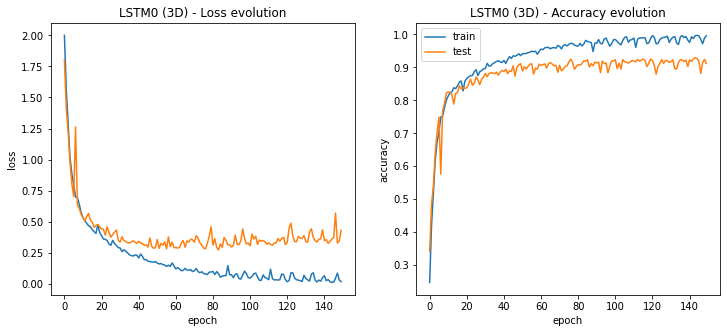

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].set(title="LSTM0 (3D) - Loss evolution")
ax[0].plot(losses_accs_LSTM03D[0], label="train")
ax[0].plot(losses_accs_LSTM03D[1], label="test")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")

ax[1].set(title="LSTM0 (3D) - Accuracy evolution")
ax[1].plot(losses_accs_LSTM03D[2], label="train")
ax[1].plot(losses_accs_LSTM03D[3], label="test")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")

plt.legend()
plt.savefig("./models_saved/LSTM03D_loss_acc.png")
plt.show()

In case the previous cell result disappear:

![losses and accuracies](./models_saved/LSTM03D_loss_acc.png)

In [24]:
model_LSTM03D = LSTM0(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D.to(device)
model_LSTM03D.load_state_dict(torch.load("./models_saved/LSTM03D.pt"))
model_LSTM03D.eval()

LSTM0(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

#### *2.2.B On Masked Data*

As a reminder:

![skeleton](./assets/skeleton.png)

In [19]:
class HumanActionDataset3D_masked(Dataset):

    def __init__(self, data_dir, data_files, classes, flatten=False, masked_percentage=0, max_hide=0):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.flatten =  flatten
        self.masked_percentage = masked_percentage # chance to have some body parts hide
        self.max_hide = max(0, min(max_hide,25)) # maximum number of body parts to hide

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if np.random.random() < self.masked_percentage:
            nb_to_hide = np.random.randint(low=1, high=self.max_hide+1)
            parts_to_hide = np.random.choice(a=25, size=nb_to_hide, replace=False)
            for part_to_hide in parts_to_hide:
                tensor[:,part_to_hide,:] = -10
        if self.flatten:
            tensor = tensor.reshape((tensor.shape[0], tensor.shape[1]*tensor.shape[2]))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [20]:
HAD3D_masked = HumanActionDataset3D_masked(data3D_dir, data3D_files, classes, flatten=True, masked_percentage=0.25, max_hide=10)

In [21]:
train_dataset3D_masked, val_dataset3D_masked = torch.utils.data.random_split(HAD3D_masked, [int(0.80*len(HAD3D_masked)), len(HAD3D_masked)-int(0.80*len(HAD3D_masked))])

train_dataloader3D_masked = torch.utils.data.DataLoader(dataset=train_dataset3D_masked, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader3D_masked = torch.utils.data.DataLoader(dataset=val_dataset3D_masked, batch_size=32, collate_fn=PadSequence(), shuffle=True)

In [22]:
# we use the model trained previously as a base (thus we have a pretrained model)
model_LSTM03D_masked = LSTM0(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D_masked.to(device)
model_LSTM03D_masked.load_state_dict(torch.load("./models_saved/LSTM03D.pt"))
model_LSTM03D_masked.eval()

LSTM0(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [23]:
criterion_LSTM03D_masked = nn.CrossEntropyLoss()
optimizer_LSTM03D_masked = torch.optim.Adam(params=model_LSTM03D_masked.parameters(), lr=1e-4)
lr_scheduler_LSTM03D_masked = torch.optim.lr_scheduler.StepLR(optimizer_LSTM03D_masked, step_size=10, gamma=0.1)

In [151]:
nb_epochs = 100
epoch_print_frequence = 10

In [152]:
losses_accs_LSTM03D_masked = train_model(model_LSTM03D_masked, criterion_LSTM03D_masked, optimizer_LSTM03D_masked, nb_epochs, epoch_print_frequence, train_dataloader3D_masked, val_dataloader3D_masked)
torch.save(model_LSTM03D_masked.state_dict(), "./models_saved/LSTM03Dmasked.pt")

epochs 10 (107 s) | train loss : 0.58115924461067 | val loss : 0.6298654570623681 | train acc : 0.7809187279151943 | val acc : 0.7633902295467923
epochs 20 (216 s) | train loss : 0.5507918504053648 | val loss : 0.6135691950718561 | train acc : 0.7912249705535924 | val acc : 0.7698646262507357
epochs 30 (327 s) | train loss : 0.5344218007975341 | val loss : 0.5816177084882468 | train acc : 0.7947585394581861 | val acc : 0.7810476751030018
epochs 40 (439 s) | train loss : 0.536429779385457 | val loss : 0.5874539450914772 | train acc : 0.7985865724381626 | val acc : 0.7828134196586227
epochs 50 (545 s) | train loss : 0.5158939542764789 | val loss : 0.5878970849293249 | train acc : 0.7991755005889282 | val acc : 0.7798705120659212
epochs 60 (644 s) | train loss : 0.4852598936345096 | val loss : 0.5628356803898458 | train acc : 0.8130153121319199 | val acc : 0.7845791642142437
epochs 70 (750 s) | train loss : 0.44493677148796584 | val loss : 0.5315047058242338 | train acc : 0.83421672555948

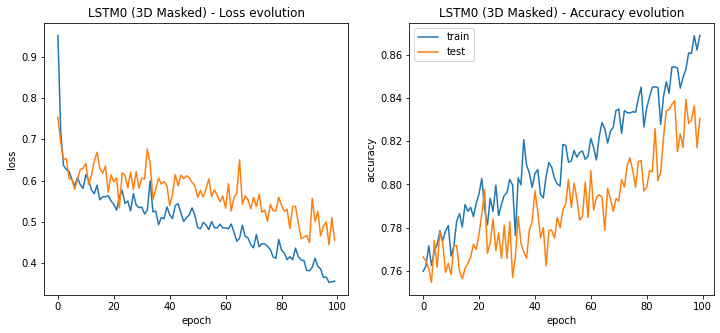

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].set(title="LSTM0 (3D Masked) - Loss evolution")
ax[0].plot(losses_accs_LSTM03D_masked[0], label="train")
ax[0].plot(losses_accs_LSTM03D_masked[1], label="test")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")

ax[1].set(title="LSTM0 (3D Masked) - Accuracy evolution")
ax[1].plot(losses_accs_LSTM03D_masked[2], label="train")
ax[1].plot(losses_accs_LSTM03D_masked[3], label="test")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")

plt.legend()
plt.savefig("./models_saved/LSTM03Dmasked_loss_acc.png")
plt.show()

In case the previous cell result disappear:
![losses and accuracies](./models_saved/LSTM03Dmasked_loss_acc.png)

In [14]:
model_LSTM03D_masked = LSTM0(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D_masked.to(device)
model_LSTM03D_masked.load_state_dict(torch.load("./models_saved/LSTM03Dmasked.pt"))
model_LSTM03D_masked.eval()

LSTM0(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

#### *2.2.B On Part of the sequences (Not masked)*

In [15]:
class HumanActionDataset3D_part(Dataset):

    def __init__(self, data_dir, data_files, classes, flatten=False, min_percentage=1):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.flatten =  flatten
        self.min_percentage = max(0,min(min_percentage,1))

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if self.min_percentage < 1:
            percentage = np.random.randint(low=int(100*self.min_percentage), high=100)/100
            max_length = int(percentage * tensor.shape[0])
            tensor = tensor[:max_length,:,:]
        if self.flatten:
            tensor = tensor.reshape((tensor.shape[0], tensor.shape[1]*tensor.shape[2]))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [16]:
HAD3D_part = HumanActionDataset3D_part(data3D_dir, data3D_files, classes, flatten=True, min_percentage=0.5)

In [17]:
train_dataset3D_part, val_dataset3D_part = torch.utils.data.random_split(HAD3D_part, [int(0.80*len(HAD3D_part)), len(HAD3D_part)-int(0.80*len(HAD3D_part))])

train_dataloader3D_part = torch.utils.data.DataLoader(dataset=train_dataset3D_part, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader3D_part = torch.utils.data.DataLoader(dataset=val_dataset3D_part, batch_size=32, collate_fn=PadSequence(), shuffle=True)

In [31]:
# we use the model trained previously as a base (thus we have a pretrained model)
model_LSTM03D_part = LSTM0(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D_part.to(device)
model_LSTM03D_part.load_state_dict(torch.load("./models_saved/LSTM03D.pt"))
model_LSTM03D_part.eval()

LSTM0(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [32]:
criterion_LSTM03D_part = nn.CrossEntropyLoss()
optimizer_LSTM03D_part = torch.optim.Adam(params=model_LSTM03D_part.parameters(), lr=1e-4)
lr_scheduler_LSTM03D_part = torch.optim.lr_scheduler.StepLR(optimizer_LSTM03D_part, step_size=10, gamma=0.1)

In [33]:
nb_epochs = 100
epoch_print_frequence = 10

In [34]:
losses_accs_LSTM03D_part = train_model(model_LSTM03D_part, criterion_LSTM03D_part, optimizer_LSTM03D_part, nb_epochs, epoch_print_frequence, train_dataloader3D_part, val_dataloader3D_part)
torch.save(model_LSTM03D_part.state_dict(), "./models_saved/LSTM03Dpart.pt")

epochs 10 (100 s) | train loss : 0.3197390874541701 | val loss : 0.35680093781815636 | train acc : 0.8881036513545347 | val acc : 0.8775750441436139
epochs 20 (202 s) | train loss : 0.25369053407454156 | val loss : 0.3824529650586623 | train acc : 0.9118080094228505 | val acc : 0.8834608593290171
epochs 30 (322 s) | train loss : 0.21137374013382504 | val loss : 0.3458937228553825 | train acc : 0.9215253239104829 | val acc : 0.8875809299587993
epochs 40 (444 s) | train loss : 0.16751890530713567 | val loss : 0.317049786793413 | train acc : 0.9400765606595995 | val acc : 0.8964096527369041
epochs 50 (558 s) | train loss : 0.15713320516854384 | val loss : 0.35550261316476045 | train acc : 0.9464075382803298 | val acc : 0.8905238375515009
epochs 60 (672 s) | train loss : 0.12650363192294545 | val loss : 0.35247481931690816 | train acc : 0.9527385159010601 | val acc : 0.8887580929958799
epochs 70 (787 s) | train loss : 0.12347455665320507 | val loss : 0.3322816133775093 | train acc : 0.9558

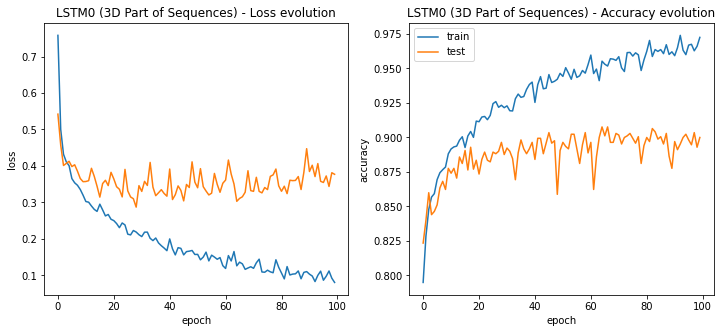

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].set(title="LSTM0 (3D Part of Sequences) - Loss evolution")
ax[0].plot(losses_accs_LSTM03D_part[0], label="train")
ax[0].plot(losses_accs_LSTM03D_part[1], label="test")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")

ax[1].set(title="LSTM0 (3D Part of Sequences) - Accuracy evolution")
ax[1].plot(losses_accs_LSTM03D_part[2], label="train")
ax[1].plot(losses_accs_LSTM03D_part[3], label="test")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")

plt.legend()
plt.savefig("./models_saved/LSTM03Dpart_loss_acc.png")
plt.show()

In [19]:
model_LSTM03D_part = LSTM0(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D_part.to(device)
model_LSTM03D_part.load_state_dict(torch.load("./models_saved/LSTM03Dpart.pt"))
model_LSTM03D_part.eval()

LSTM0(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

### *2.3. Evaluate the models*

In [28]:
def accuracy_per_sequence_percentage(models, dataset, action_class, min_percentage=0.1, max_percentage=1, steps=10):
    
    percentages = np.linspace(start=min_percentage, stop=max_percentage, num=steps)
    accuracies_per_model = [[]] * len(models)
    n = len(dataset)
    sm = nn.Softmax(dim=1)

    N = sum([dataset[i][1] == action_class for i in range(n)])
    
    for i,percentage in enumerate(percentages):
        
        accuracies = np.zeros(len(models))
        
        for j in range(n):
            
            tensor,label = dataset[j]

            if label == action_class:

                tensor = tensor[:int(percentage * tensor.shape[0]),:]
                tensor = tensor.to(device)
                tensor = tensor.reshape(1,tensor.shape[0],75)
                
                for k,model in enumerate(models):

                    accuracies[k] += int(sm(model(tensor)).argmax().item()==label)
        
        for k in range(len(models)):

            accuracies_per_model[k] = accuracies_per_model[k] + [accuracies[k]/N]

    return accuracies_per_model

In [37]:
results = [
    accuracy_per_sequence_percentage([model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part], HAD3D, action_class=elem) for elem in range(len(classes))
]

<Figure size 432x288 with 0 Axes>

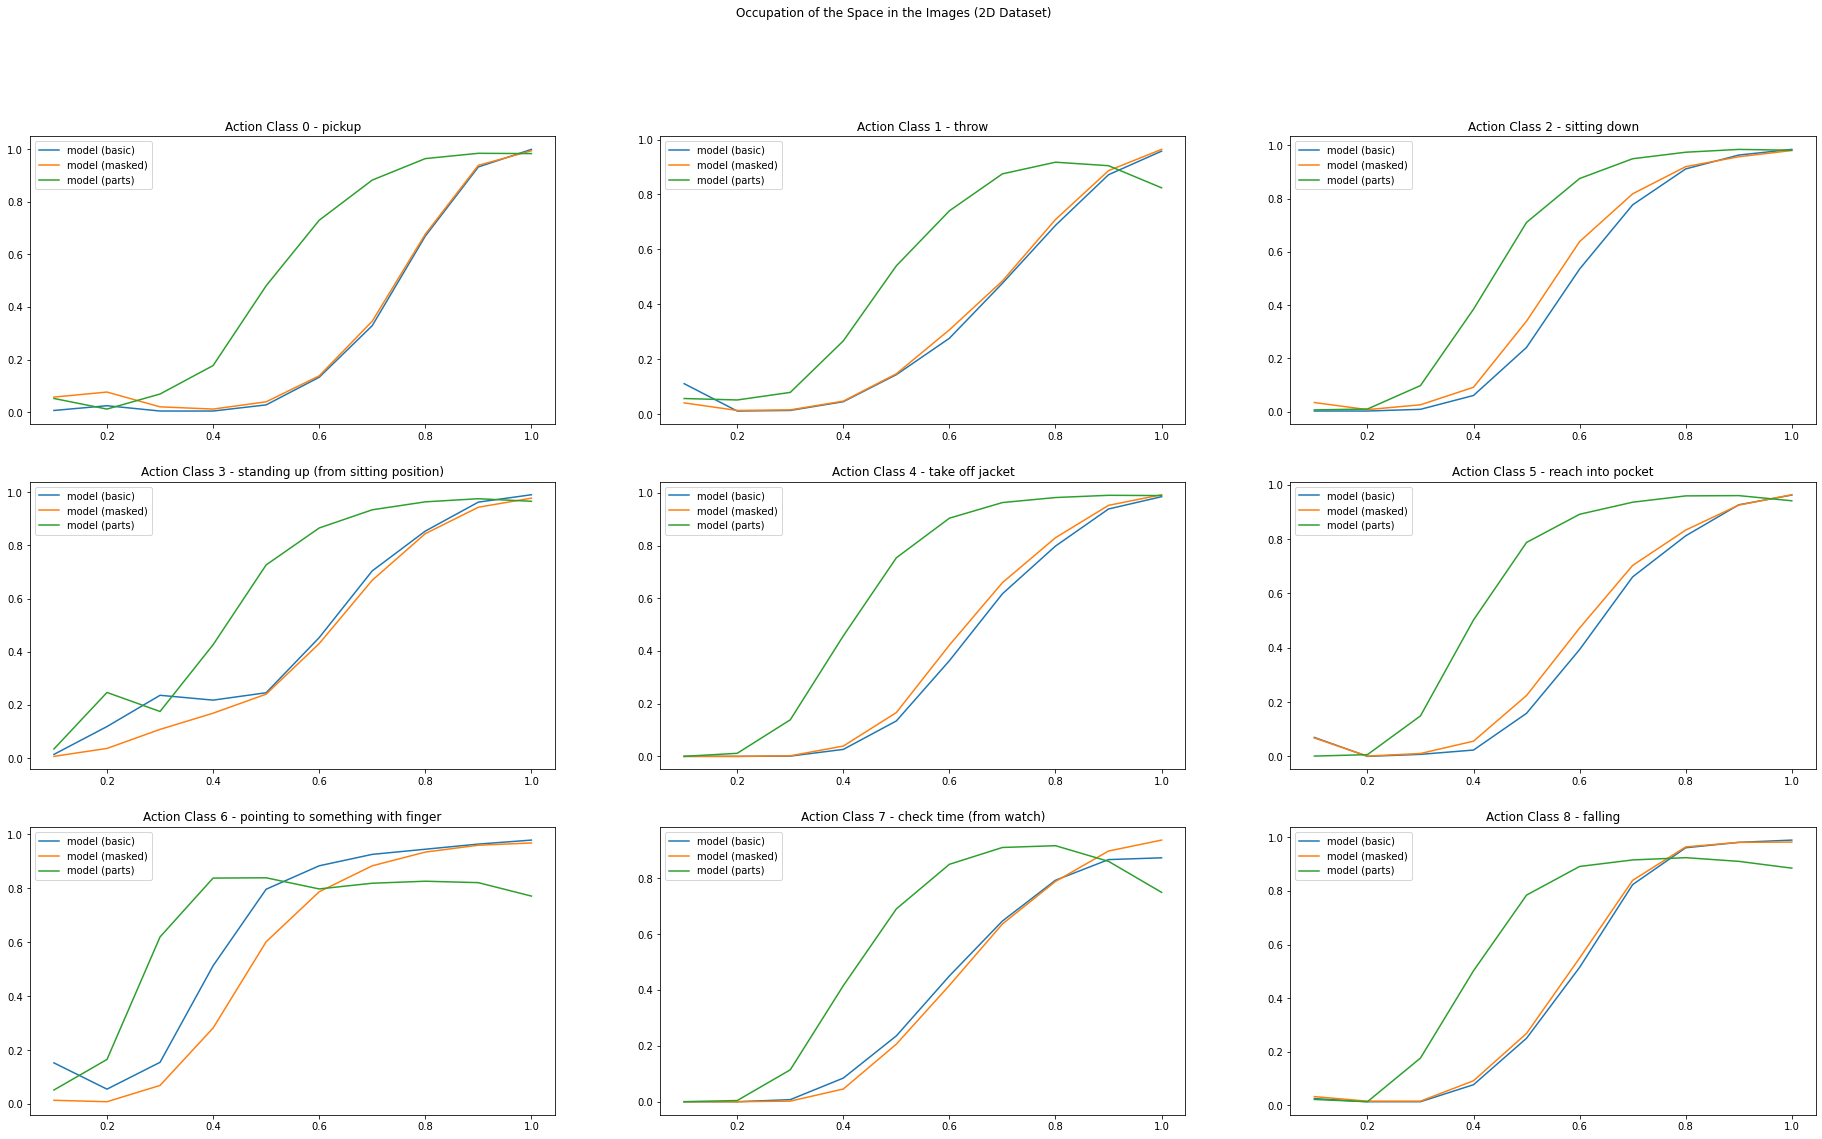

In [ ]:
plt.clf()

fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figheight(18)
fig.set_figwidth(32)

x = np.linspace(start=0.1, stop=1, num=10)

for i in range(len(classes)):

    ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
    accuracies = results[i]
    ax[i//3][i%3].plot(x, accuracies[0], label="model (basic)")
    ax[i//3][i%3].plot(x, accuracies[1], label="model (masked)")
    ax[i//3][i%3].plot(x, accuracies[2], label="model (parts)")
    ax[i//3][i%3].legend()

fig.suptitle("Occupation of the Space in the Images (2D Dataset)")
plt.show()

### *2.4. Dynamic Prediction*

In [36]:
class DynamicModel():

    def __init__(self, model):

        self.model = model
        self.state = torch.zeros((1,75))
        self.sm = nn.Softmax(dim=1)    

    def clean(self):
        self.state = torch.zeros((1,75))
    
    def predict(self, frame):
        self.state = torch.concat(self.state, frame)
        x = self.state
        x = x.to(device)
        x = x.reshape(1,x.shape[0],75)
        prediction = int(self.sm(self.model(x)).argmax().item())
        action = actions[classes[prediction]]
        return prediction, action

In [ ]:
dynamicModel3D = DynamicModel(model_LSTM03D) 
dynamicModel3Dmasked = DynamicModel(model_LSTM03D_masked) 
dynamicModel3Dpart = DynamicModel(model_LSTM03D_part) 

### *2.?. Grid Search* ***TODO***

Let's find optimal parameters for this simple model among a relatively small set of hyperparameters.

___
___